![Header](https://storage.googleapis.com/pr-newsroom-wp/1/2021/09/Header_copy.png)

# Spotify Song Recommendation Based on Audio Features
***

AUTHOR: [SUMEDH BHARDWAJ](https://www.linkedin.com/in/sumedh-bhardwaj-932767202/)

# Table of Contents
***

# Overview/Background
***
I have been an avid music listener my whole life which leads me to make tons of playlists on Spotify. Creating Playlists manually can be very time consuming and inefficient. I have always wondered if there was a way to make a playlist based on the mood of a song and unfortunately spotify doesnt have an option for that. So I wanted to create a recommendation system that can take an artist and various audio features such as tempo, valence(vibe), danceability of a song to create automatic playlists. I Am My own stakeholder but this can also be helpful to other enthusiasts like me out there. Give background as to why I chose Spotify, explain that they have huge database of 70 million songs. talk about their web api.

# Objective: Why Not Just Use Spotify Radio? 
***
They do not allow you to use the audio features of tracks. When you make a spotify radio seperate playlist, you may not necessarily like all the songs that they give. Maybe you wanted more danceable songs than songs with tempo that was given. Using the song recommendation feature that I have made, you can decide which types of songs you want to based on that song corresponding to the artist you want to listen to.

# Methods
***

This recommendation system was only content-based filtering and based on audio features of a song such as danceability, valence, energy & loudness. The models that were used were Cosine Similarity, Nearest Neighbors, & KNN Clustering. My own subjective listening and mean-distances were used to select the best model.

# Data
***

Data came from 2 sources:

- API Calls of Spotify's [Web API](https://developer.spotify.com/documentation/web-api/) to get [audio features](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features) for each track. 
- The [Spotify Million Playlist](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge) Dataset which contained 1,000 separate JSON files filled with 1,000 playlist each. I took a random sample of 10 files due to computational and time costs to use for my project.

## Library Imports
***

In [1307]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pandas.io.json import json_normalize
import sys, re, json, os, datetime
import spotipy
import warnings
warnings.filterwarnings('ignore')

from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline


%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

# Data Imports, Convertion, Cleaning, Concatenation

- 10 random JSON files from the Spotify Million Playlist Dataset were imported and converted to DataFrames which then were all combined into a concatenated DataFrame to start basic data cleaning
- Data cleaning was done such as dropping duplicates and finally a random sample of 12,000 songs were collected from the merged dataset and put into a new DataFrame to not exceed the Spotify API call limit
- After API Calls were done to get audio features for the random sample, the Spotify Million Playlist dataset and spotify audio features datasets were merged together to begin EDA.

***

Open a random 10 files from the Spotify Million Playlist Dataset and expanded to include the specific songs in each playlist

In [86]:
with open("mpd.slice.0-999.json","r") as f: 
    df = json.load(f)
df = pd.DataFrame(df["playlists"])
df

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,tracks,num_edits,duration_ms,num_artists,description
0,Throwbacks,false,0,1493424000,52,47,1,"[{'pos': 0, 'artist_name': 'Missy Elliott', 't...",6,11532414,37,NaN
1,Awesome Playlist,false,1,1506556800,39,23,1,"[{'pos': 0, 'artist_name': 'Survivor', 'track_...",5,11656470,21,NaN
2,korean,false,2,1505692800,64,51,1,"[{'pos': 0, 'artist_name': 'Hoody', 'track_uri...",18,14039958,31,NaN
3,mat,false,3,1501027200,126,107,1,"[{'pos': 0, 'artist_name': 'Camille Saint-Saën...",4,28926058,86,NaN
4,90s,false,4,1401667200,17,16,2,"[{'pos': 0, 'artist_name': 'The Smashing Pumpk...",7,4335282,16,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
995,old,false,995,1507852800,41,40,1,"[{'pos': 0, 'artist_name': 'Katrina', 'track_u...",8,9917901,36,NaN
996,Daze,false,996,1479254400,17,17,1,"[{'pos': 0, 'artist_name': 'PARTYNEXTDOOR', 't...",13,3699248,15,NaN
997,rap,false,997,1410307200,119,98,1,"[{'pos': 0, 'artist_name': 'LoveRance', 'track...",63,27538723,82,NaN
998,Country,false,998,1507939200,108,75,1,"[{'pos': 0, 'artist_name': 'Hunter Hayes', 'tr...",37,24950143,40,NaN


In [328]:
# Taking the tracks for each playlist & creating a separate dataframe for it
track_df = []
ply_counter = 0
for track in df['tracks']:
    for one_track in track:
        x = list(one_track.values())
        
        # Making sure each track in the dataframe has a column to indicate which playlist they came from
        x.append(df['name'][ply_counter])
        track_df.append(x)
    ply_counter += 1

track_df = pd.DataFrame(track_df, columns = ['Playlist_pos', 'artist_name','track_uri','artist_uri','track_name','album_uri','duration_ms','album_name','playlist'])  

# Check df
track_df.head(10)

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,Throwbacks
1,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone,Throwbacks
2,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit),Throwbacks
3,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified,Throwbacks
4,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot,Throwbacks
...,...,...,...,...,...,...,...,...,...
67498,39,James Arthur,spotify:track:5uCax9HTNlzGybIStD3vDh,spotify:artist:4IWBUUAFIplrNtaOHcJPRM,Say You Won't Let Go,spotify:album:7oiJYvEJHsmYtrgviAVIBD,211466,Back from the Edge,thinking of you
67499,40,Big Words,spotify:track:0P1oO2gREMYUCoOkzYAyFu,spotify:artist:0sHN89qak07mnug3LVVjzP,The Answer,spotify:album:5jrsRHRAmetu5e7RRBoxj7,263679,"Hollywood, a Beautiful Coincidence",thinking of you
67500,41,Allan Rayman,spotify:track:2oM4BuruDnEvk59IvIXCwn,spotify:artist:6Yv6OBXD6ZQakEljaGaDAk,25.22,spotify:album:3CbNgBzI7r9o0F6VjH9sTY,189213,Roadhouse 01,thinking of you
67501,42,Jon Jason,spotify:track:4Ri5TTUgjM96tbQZd5Ua7V,spotify:artist:77bNdkKYBBmc30CisCA6tE,Good Feeling,spotify:album:2dZ7oVNQBeLlpoUYfbEsJP,194720,Good Feeling,thinking of you


In [89]:
with open("mpd.slice.238000-238999.json","r") as f: 
    df1 = json.load(f)
df1 = pd.DataFrame(df1["playlists"])

In [92]:
# Taking the tracks for each playlist & creating a separate dataframe for it
track_df1 = []
ply_counter = 0
for track in df1['tracks']:
    for one_track in track:
        x = list(one_track.values())
        
        # Making sure each track in the dataframe has a column to indicate which playlist they came from
        x.append(df1['name'][ply_counter])
        track_df1.append(x)
    ply_counter += 1

track_df1 = pd.DataFrame(track_df1, columns = ['Playlist_pos', 'artist_name','track_uri','artist_uri','track_name','album_uri','duration_ms','album_name','playlist'])  

# Check df
track_df1.head(10)

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,0,Gramatik,spotify:track:6aBFjYfhZrgJtxiKaip1BH,spotify:artist:179BpmLkQCRIoU68Co80f5,Skylight,spotify:album:2jufxlYnmvY235bVECkCCq,226333,"Beatz & Pieces, Vol. 1",Beats
1,1,Shlohmo,spotify:track:629Cjw0fUyZUMkBjnjttDR,spotify:artist:6y80I9YZi4DOpbaSUlL725,Places,spotify:album:7BjSjxv8CfoUXRTyW329x2,302210,Bad Vibes,Beats
2,2,Cuthead,spotify:track:1Q5tfzvk1Yx6ZRYKFGsaz9,spotify:artist:1z39BS5hTB0I2kL3w8ux5n,The Poncho,spotify:album:76qwU0D2YDNbIpeRPsUjFx,215500,Total Sellout,Beats
3,3,Samiyam,spotify:track:34wIz7WMyKRfJOenJ3sXYc,spotify:artist:56j1OkSq0AMCgZGKVNc8GP,27,spotify:album:7C2a9Ys91AnGqrTJHXj2ln,58026,Rap Beats Vol. 1,Beats
4,4,PRhyme,spotify:track:5paeaGXCDvRkMkF1rYuSm6,spotify:artist:4ypEjUTTCcPB0dgjQBQyf5,Courtesy - Instrumental,spotify:album:4XiW2dDo7luQxiBCW3Wc3c,212298,PRhyme Instrumentals,Beats
5,5,Baths,spotify:track:4qnvETk1dIsnddsWAEsp2B,spotify:artist:5zS8r5hRRk1jzD41yYS1NO,Animals,spotify:album:2Dt2BZKqxIM5b8hdfmPlP7,198400,Cerulean,Beats
6,6,Photay,spotify:track:3r2CpMRlTWexGhZhQeJtAo,spotify:artist:1MSxOmIt7uYgvPydd1tU8F,No Sass,spotify:album:18rcvgzvr5DMsPNOBwL5Cz,229091,Photay,Beats
7,7,Bahwee,spotify:track:3r5V1X6jScy9VcvEq0bs49,spotify:artist:5SiL5Tx9kfR5waAA9PuHDo,Twentyinmypocket,spotify:album:1nnl1Iq2eSkqvMGsIfV5Wr,163631,Flavors,Beats
8,8,J Dilla,spotify:track:6CmsmQkg655kIZmg22IlVD,spotify:artist:0IVcLMMbm05VIjnzPkGCyp,So Far To Go,spotify:album:4qKDGFz5pQH9NJtRx7qPdb,336813,The Shining,Beats
9,9,Wu-Tang Clan,spotify:track:1zoQsi53rUb67HEo5Kl5DB,spotify:artist:34EP7KEpOjXcM2TCat1ISk,Think Differently - Instrumental,spotify:album:7GvdgeSyGWQ8x7RrchZkU3,278893,Wu-Tang Meets The Indie Culture Instrumentals,Beats


In [95]:
with open("mpd.slice.188000-188999.json","r") as f: 
    df2 = json.load(f)
df2 = pd.DataFrame(df2["playlists"])


In [96]:
# Taking the tracks for each playlist & creating a separate dataframe for it
track_df2 = []
ply_counter = 0
for track in df2['tracks']:
    for one_track in track:
        x = list(one_track.values())
        
        # Making sure each track in the dataframe has a column to indicate which playlist they came from
        x.append(df2['name'][ply_counter])
        track_df2.append(x)
    ply_counter += 1

track_df2 = pd.DataFrame(track_df2, columns = ['Playlist_pos', 'artist_name','track_uri','artist_uri','track_name','album_uri','duration_ms','album_name','playlist'])  

# Check df
track_df2.head(10)

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,0,Waylon Jennings,spotify:track:5XC3KWPe0XTTSqwxw2rqDK,spotify:artist:7wCjDgV6nqBsHguQXPAaIM,Waymore's Blues,spotify:album:3DDUesugWE5mJjTF5HFsRg,160840,Nashville Rebel,Waylon Jennings
1,1,Waylon Jennings,spotify:track:3GNxGU1AiUzWgYP7jcHj8Q,spotify:artist:7wCjDgV6nqBsHguQXPAaIM,Goin' Down Rockin',spotify:album:2sRs6dIRPjwMrIVioItuxp,238013,Goin' Down Rockin': The Last Recordings,Waylon Jennings
2,2,Waylon Jennings,spotify:track:7DLawBIVohNTngHhRnB37o,spotify:artist:7wCjDgV6nqBsHguQXPAaIM,Outlaw Shit,spotify:album:5tRSywIFhukxe4dsQgi88y,328066,Waylon Forever,Waylon Jennings
3,3,Waylon Jennings,spotify:track:5ft2hncAccU0sa0rbkwm6c,spotify:artist:7wCjDgV6nqBsHguQXPAaIM,Lonesome On'ry and Mean,spotify:album:5tRSywIFhukxe4dsQgi88y,260000,Waylon Forever,Waylon Jennings
4,4,Waylon Jennings,spotify:track:5rlMPBNBnRfROrnQAQRKvA,spotify:artist:7wCjDgV6nqBsHguQXPAaIM,If I Can Find a Clean Shirt,spotify:album:51tjd3OGtsRM68Wt3Rp62C,208693,If I Can Find a Clean Shirt,Waylon Jennings
5,5,Waylon Jennings,spotify:track:3OagKnvsDqltscWZO5TBJj,spotify:artist:7wCjDgV6nqBsHguQXPAaIM,Rough And Rowdy Days,spotify:album:1KiSAPJv57FBLmFnSLpfea,151000,20th Century Masters: The Millennium Collectio...,Waylon Jennings
6,6,Waylon Jennings,spotify:track:6EibL51h5Zplr4Dyj41nDl,spotify:artist:7wCjDgV6nqBsHguQXPAaIM,The Taker,spotify:album:3DDUesugWE5mJjTF5HFsRg,142533,Nashville Rebel,Waylon Jennings
7,7,Waylon Jennings,spotify:track:05G4Jld2muFMnWEqKVLmgq,spotify:artist:7wCjDgV6nqBsHguQXPAaIM,The Chokin' Kind,spotify:album:4LAaQJ9BnVNzNN4jOApk8O,146000,Love Of The Common People,Waylon Jennings
8,8,Waylon Jennings,spotify:track:11C0Qn1bkZ2yPhptlsJWlq,spotify:artist:7wCjDgV6nqBsHguQXPAaIM,Pretend I Never Happened,spotify:album:3DDUesugWE5mJjTF5HFsRg,181866,Nashville Rebel,Waylon Jennings
9,9,Waylon Jennings,spotify:track:1EsTeMFJW9Rk8dr4Nvt3cI,spotify:artist:7wCjDgV6nqBsHguQXPAaIM,You Can Have Her,spotify:album:3DDUesugWE5mJjTF5HFsRg,160506,Nashville Rebel,Waylon Jennings


In [98]:
with open("mpd.slice.351000-351999.json","r") as f: 
    df3 = json.load(f)
df3 = pd.DataFrame(df3["playlists"])

In [99]:
# Taking the tracks for each playlist & creating a separate dataframe for it
track_df3 = []
ply_counter = 0
for track in df3['tracks']:
    for one_track in track:
        x = list(one_track.values())
        
        # Making sure each track in the dataframe has a column to indicate which playlist they came from
        x.append(df3['name'][ply_counter])
        track_df3.append(x)
    ply_counter += 1

track_df3 = pd.DataFrame(track_df3, columns = ['Playlist_pos', 'artist_name','track_uri','artist_uri','track_name','album_uri','duration_ms','album_name','playlist'])  

# Check df
track_df3.head(10)

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,0,Halsey,spotify:track:16w8ZGVSjI4TlTLV8VimBY,spotify:artist:26VFTg2z8YR0cCuwLzESi2,Castle,spotify:album:5OZJflQcQCdZLQjtUudCin,277623,BADLANDS,Juan
1,1,Ed Sheeran,spotify:track:1Slwb6dOYkBlWal1PGtnNg,spotify:artist:6eUKZXaKkcviH0Ku9w2n3V,Thinking Out Loud,spotify:album:6NoBzYmh5gUusGPCfg0pct,281560,x,Juan
2,2,Jason Derulo,spotify:track:6jizk5lOUnfpaZXYMdfeC6,spotify:artist:07YZf4WDAMNwqr4jfgOZ8y,Trumpets,spotify:album:1OdcBxCNY52OXH0r4odXqP,217306,Tattoos,Juan
3,3,The Lumineers,spotify:track:6ZYS6QQxTLsQ6IFXdVx1r4,spotify:artist:16oZKvXb6WkQlVAjwo2Wbg,Ophelia,spotify:album:03WMNRxqKog3sBZ6G5jGDw,160106,Cleopatra,Juan
4,4,Lukas Graham,spotify:track:7129iqBafaphfc3WPCGC0L,spotify:artist:25u4wHJWxCA9vO0CzxAbK7,7 Years,spotify:album:6NQ2RNksdSKdtnlFOLJo24,237300,Lukas Graham (Blue Album),Juan
5,5,ZAYN,spotify:track:0PDUDa38GO8lMxLCRc4lL1,spotify:artist:5ZsFI1h6hIdQRw2ti0hz81,PILLOWTALK,spotify:album:5amj9zNeZ3B2EdpBgXrOZ0,202746,Mind Of Mine (Deluxe Edition),Juan
6,6,Kurt Hugo Schneider,spotify:track:2aFP72ibtJVJJEwnvv0xlz,spotify:artist:2BHswvFd8tMBizVWGcAMLm,Send My Love (To Your New Lover),spotify:album:2Q8rtQ3VdGJDBwPailR7f3,210731,Everyday Sounds I,Juan
7,7,Alessia Cara,spotify:track:1wYZZtamWTQAoj8B812uKQ,spotify:artist:2wUjUUtkb5lvLKcGKsKqsR,Here,spotify:album:3rDbA12I5duZnlwakqDdZa,199453,Know-It-All,Juan
8,8,Passenger,spotify:track:2JXnsuFhfVgLHPL1mp3xdW,spotify:artist:0gadJ2b9A4SKsB1RFkBb66,Let Her Go - Live At Spotify Amsterdam,spotify:album:6gMzMZ9HpMXosMlu2JtGti,223573,Spotify Session,Juan
9,9,The Civil Wars,spotify:track:06FVwC9lTks2JmCO9IKB4H,spotify:artist:6J7rw7NELJUCThPbAfyLIE,Girl with the Red Balloon,spotify:album:6tQjO7LXVL6byHa0ZF4emD,229520,Barton Hollow,Juan


In [100]:
with open("mpd.slice.597000-597999.json","r") as f: 
    df4 = json.load(f)
df4 = pd.DataFrame(df4["playlists"])

In [101]:
 # Taking the tracks for each playlist & creating a separate dataframe for it
track_df4 = []
ply_counter = 0
for track in df4['tracks']:
    for one_track in track:
        x = list(one_track.values())
        
        # Making sure each track in the dataframe has a column to indicate which playlist they came from
        x.append(df4['name'][ply_counter])
        track_df4.append(x)
    ply_counter += 1

track_df4 = pd.DataFrame(track_df4, columns = ['Playlist_pos', 'artist_name','track_uri','artist_uri','track_name','album_uri','duration_ms','album_name','playlist'])  

# Check df
track_df4.head(10)

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,0,Missy Elliott,spotify:track:4Z1GSvE92RKsxjzrrBJAIT,spotify:artist:2wIVse2owClT7go1WT98tk,One Minute Man (feat. Jay-Z) - Remix,spotify:album:20t54K6C80QQH7vbcpfJcP,275600,Miss E...So Addictive,90's Hip Hop
1,1,Nas,spotify:track:3qRPc4QpHGNwKFAzCdqwxA,spotify:artist:20qISvAhX20dpIbOOzGK3q,Made You Look,spotify:album:3rV1aPkrWyMs6YTvTpSbIY,203000,God's Son,90's Hip Hop
2,2,Total,spotify:track:174UISK3l7VRbigEHxEev7,spotify:artist:1urjDGTd4iBze91Z1W1gu7,Can't You See (feat. The Notorious B.I.G.),spotify:album:4uLoT81NWVFx09mkfnGCHb,281880,Total,90's Hip Hop
3,3,The Notorious B.I.G.,spotify:track:61fT12l0R16DiB9dd4zkfy,spotify:artist:5me0Irg2ANcsgc93uaYrpb,Just Playing (Dreams),spotify:album:2HTbQ0RHwukKVXAlTmCZP2,163466,Ready To Die The Remaster,90's Hip Hop
4,4,The Notorious B.I.G.,spotify:track:7KwZNVEaqikRSBSpyhXK2j,spotify:artist:5me0Irg2ANcsgc93uaYrpb,Hypnotize - 2014 Remastered Version,spotify:album:7dRdaGSxgcBdJnrOviQRuB,229826,Life After Death (Remastered Edition),90's Hip Hop
5,5,The Notorious B.I.G.,spotify:track:5ByAIlEEnxYdvpnezg7HTX,spotify:artist:5me0Irg2ANcsgc93uaYrpb,Juicy,spotify:album:2HTbQ0RHwukKVXAlTmCZP2,302693,Ready To Die The Remaster,90's Hip Hop
6,6,The Notorious B.I.G.,spotify:track:2g8HN35AnVGIk7B8yMucww,spotify:artist:5me0Irg2ANcsgc93uaYrpb,Big Poppa,spotify:album:2HTbQ0RHwukKVXAlTmCZP2,252746,Ready To Die The Remaster,90's Hip Hop
7,7,The Notorious B.I.G.,spotify:track:7fXhkARAtS66kxexMIAx8O,spotify:artist:5me0Irg2ANcsgc93uaYrpb,One More Chance/Stay With Me - Remix,spotify:album:5XqEf16OrHdmMoNS1b6WDg,268706,Greatest Hits,90's Hip Hop
8,8,Junior M.A.F.I.A.,spotify:track:53oWwSxPuyH2cjYKXH8fgO,spotify:artist:3r0OeTcOw37N9juMYyyw39,Get Money - LP-Explicit Version,spotify:album:02GVhWjMuoQBQUtNhjWsnG,274937,Conspiracy,90's Hip Hop
9,9,The Notorious B.I.G.,spotify:track:2KFg8kjYy0rYjWsXGhEQHN,spotify:artist:5me0Irg2ANcsgc93uaYrpb,Who Shot Ya,spotify:album:2HTbQ0RHwukKVXAlTmCZP2,319373,Ready To Die The Remaster,90's Hip Hop


In [102]:
with open("mpd.slice.656000-656999.json","r") as f: 
    df5 = json.load(f)
df5 = pd.DataFrame(df5["playlists"])

In [103]:
# Taking the tracks for each playlist & creating a separate dataframe for it
track_df5 = []
ply_counter = 0
for track in df5['tracks']:
    for one_track in track:
        x = list(one_track.values())
        
        # Making sure each track in the dataframe has a column to indicate which playlist they came from
        x.append(df5['name'][ply_counter])
        track_df5.append(x)
    ply_counter += 1

track_df5 = pd.DataFrame(track_df5, columns = ['Playlist_pos', 'artist_name','track_uri','artist_uri','track_name','album_uri','duration_ms','album_name','playlist'])  

# Check df
track_df5.head(10)

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,0,21 Savage,spotify:track:4gmmRb6bZJffOOiww1JGTO,spotify:artist:1URnnhqYAYcrqrcwql10ft,No Heart,spotify:album:4I3EcXD4e3KcEoDJfFEZ5b,235040,Savage Mode,My Tunes
1,1,21 Savage,spotify:track:6fwdbPMwP1zVStm8FybmkO,spotify:artist:1URnnhqYAYcrqrcwql10ft,X (feat. Future),spotify:album:4I3EcXD4e3KcEoDJfFEZ5b,258880,Savage Mode,My Tunes
2,2,21 Savage,spotify:track:3xAXYCtd98G5G0SSJAHtqd,spotify:artist:1URnnhqYAYcrqrcwql10ft,Dip Dip,spotify:album:1HSyuTHvLXMWyPJQGnQTLw,151614,Slaughter King,My Tunes
3,3,21 Savage,spotify:track:6g0TAJ1grweRwBMLQyiZFb,spotify:artist:1URnnhqYAYcrqrcwql10ft,Famous,spotify:album:4QUNWTw2FsIz722xjUjFJw,234280,Issa Album,My Tunes
4,4,21 Savage,spotify:track:2fQrGHiQOvpL9UgPvtYy6G,spotify:artist:1URnnhqYAYcrqrcwql10ft,Bank Account,spotify:album:4QUNWTw2FsIz722xjUjFJw,220306,Issa Album,My Tunes
5,5,6LACK,spotify:track:4AtZRwSR8BOTTQg5ihSggt,spotify:artist:4IVAbR2w4JJNJDDRFP3E83,PRBLMS,spotify:album:7iwGw8ob3YLqZrbKzGFnHi,246773,FREE 6LACK,My Tunes
6,6,6LACK,spotify:track:1MQ8ydvrTnn2QJgXFATJvD,spotify:artist:4IVAbR2w4JJNJDDRFP3E83,Ex Calling,spotify:album:7iwGw8ob3YLqZrbKzGFnHi,211960,FREE 6LACK,My Tunes
7,7,2 Chainz,spotify:track:7s8NiGsmHTT7K9CLIKvkSW,spotify:artist:17lzZA2AlOHwCwFALHttmp,A Milli Billi Trilli,spotify:album:0HiyOnSs0O9vptexgk9Bh4,195426,TrapAvelli Tre,My Tunes
8,8,2 Chainz,spotify:track:1gpSrGUfU3F9TOzPlEyLxH,spotify:artist:17lzZA2AlOHwCwFALHttmp,Gotta Lotta,spotify:album:56TQNcSoy3eQpyWtNwQnrD,214720,COLLEGROVE,My Tunes
9,9,2 Chainz,spotify:track:39pS70eeDvyCAF3t8NAlVV,spotify:artist:17lzZA2AlOHwCwFALHttmp,Good Drank,spotify:album:5vvvo79z68vWj9yimoygfS,222706,Pretty Girls Like Trap Music,My Tunes


In [104]:
with open("mpd.slice.777000-777999.json","r") as f: 
    df6 = json.load(f)
df6 = pd.DataFrame(df6["playlists"])

In [105]:
# Taking the tracks for each playlist & creating a separate dataframe for it
track_df6 = []
ply_counter = 0
for track in df6['tracks']:
    for one_track in track:
        x = list(one_track.values())
        
        # Making sure each track in the dataframe has a column to indicate which playlist they came from
        x.append(df6['name'][ply_counter])
        track_df6.append(x)
    ply_counter += 1

track_df6 = pd.DataFrame(track_df6, columns = ['Playlist_pos', 'artist_name','track_uri','artist_uri','track_name','album_uri','duration_ms','album_name','playlist'])  

# Check df
track_df6.head(10)

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,0,Luke Bryan,spotify:track:1PoGWZbJPGmViVi7CYbDUK,spotify:artist:0BvkDsjIUla7X0k6CSWh1I,Drink A Beer,spotify:album:5M8gr5RV2eR6UkztC69ogB,202626,Crash My Party,County
1,1,Luke Bryan,spotify:track:03fT3OHB9KyMtGMt2zwqCT,spotify:artist:0BvkDsjIUla7X0k6CSWh1I,Play It Again,spotify:album:5M8gr5RV2eR6UkztC69ogB,226866,Crash My Party,County
2,2,Luke Bryan,spotify:track:5HGibWoxnkYSkl6mHmAlOE,spotify:artist:0BvkDsjIUla7X0k6CSWh1I,That's My Kind Of Night,spotify:album:5M8gr5RV2eR6UkztC69ogB,190186,Crash My Party,County
3,3,Luke Bryan,spotify:track:3b7CDTKB0SRTmQ6ytYi5vZ,spotify:artist:0BvkDsjIUla7X0k6CSWh1I,Drunk On You,spotify:album:4ybWq0AegFFAvHULAe7q0K,213546,Tailgates & Tanlines,County
4,4,Luke Bryan,spotify:track:7nbYuquNV8MvCY0Ut7YpLd,spotify:artist:0BvkDsjIUla7X0k6CSWh1I,Shut It Down,spotify:album:5M8gr5RV2eR6UkztC69ogB,195973,Crash My Party,County
5,5,Lee Brice,spotify:track:5Kb5utdaR6qXYZ9WpgoKWm,spotify:artist:5Zq7R5qmi58ByYyBQTlNuk,Drinking class,spotify:album:1Ug5qpIXouUHY5hpFj6575,207346,I Don't Dance,County
6,6,Lee Brice,spotify:track:2YCQff1CDLnQ4dzjAfE1VG,spotify:artist:5Zq7R5qmi58ByYyBQTlNuk,I Drive Your Truck,spotify:album:00V6Eg95EFSbvLiQpMUmCE,243653,I Drive Your Truck,County
7,7,Lee Brice,spotify:track:5aj0xPGiEUN3aI2oOYu14S,spotify:artist:5Zq7R5qmi58ByYyBQTlNuk,I Don't Dance,spotify:album:2XIhZ9IjqoIN5V6dfKHzCn,221173,I Don't Dance,County
8,8,Blake Shelton,spotify:track:3JffB4CABj9lA0NC63kbCp,spotify:artist:1UTPBmNbXNTittyMJrNkvw,She's Got a Way With Words,spotify:album:4JmphteFDt5gNZbgraR9Dc,190986,If I'm Honest,County
9,9,Blake Shelton,spotify:track:0y44Oz1T9uWDKg4SFDWRWH,spotify:artist:1UTPBmNbXNTittyMJrNkvw,Honey Bee,spotify:album:7qyfoJ9YCVfBnePdxBFbhx,210720,Loaded: The Best Of Blake Shelton,County


In [106]:
with open("mpd.slice.828000-828999.json","r") as f: 
    df7 = json.load(f)
df7 = pd.DataFrame(df7["playlists"])

In [107]:
# Taking the tracks for each playlist & creating a separate dataframe for it
track_df7 = []
ply_counter = 0
for track in df7['tracks']:
    for one_track in track:
        x = list(one_track.values())
        
        # Making sure each track in the dataframe has a column to indicate which playlist they came from
        x.append(df7['name'][ply_counter])
        track_df7.append(x)
    ply_counter += 1

track_df7 = pd.DataFrame(track_df7, columns = ['Playlist_pos', 'artist_name','track_uri','artist_uri','track_name','album_uri','duration_ms','album_name','playlist'])  

# Check df
track_df7.head(10)

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,0,Faze Wave,spotify:track:0wQbk9sAkZflH2ht0FC5G7,spotify:artist:7rsBReXv6wZK0s0nGN3yzF,Makeout,spotify:album:0ONVr5a3zRKThzRJK9aaBq,190749,Makeout,Makeout
1,1,Hitting The Rhodes,spotify:track:3uZlxLpNhom1ts3GOGS6po,spotify:artist:60haZt1bS1moHbG1Vjd3oq,Hey Ya Cover By Hitting The Rhodes,spotify:album:2Cjcaf9QxTkc6ZseqEk2HT,146227,Hey Ya Cover By Hitting The Rhodes,Makeout
2,2,Concorde,spotify:track:4fmU11hc9cNOvnD1rvddUl,spotify:artist:5gSzpQeKekCGJTR9hcWwKF,Just Kiss Her,spotify:album:23qAGuV2cnNN2wR8zgayIC,302532,Summer House,Makeout
3,3,The Happy Fits,spotify:track:4YDbjd5K0tNntyeWg0HSY8,spotify:artist:73rPcaYEhBd0UuVZBqqyQJ,Drink,spotify:album:2L4dQBiAsOxEFwjGqduCEI,230990,Awfully Apeelin',Makeout
4,4,SWMRS,spotify:track:0Ceozg27V0Ws9jgQixD8fr,spotify:artist:7dLkuQHF2ijbK6jiLFyIWM,Lose It,spotify:album:3KbuvIJRqejRJ4gtO9xwC3,240533,Drive North,Makeout
5,5,Beach Weather,spotify:track:04wODYKrbLNe7LTOaOPX3i,spotify:artist:7I3bkknknQkIiatWiupQgD,"Sex, Drugs, Etc.",spotify:album:6ygLpSyAvRSKGZw1LZkxOX,196784,Chit Chat,Makeout
6,6,Folded Like Fabric,spotify:track:3WZISkRbc2ppp69sQch8cq,spotify:artist:2Gt8bzahH9RSMrH6heY2vF,Falling and You Caught Me,spotify:album:21h2o7XD2TnrwNCtwrn1Uh,205466,Falling and You Caught Me,Makeout
7,7,Elliot Root,spotify:track:3hbYJfgdAcfCsKFEZS7E5s,spotify:artist:2czQ8vG4i3wBWxfsAt4yqw,Body Down,spotify:album:0bTG6s0dKmgvvbrfyGnQtQ,330710,2,Makeout
8,8,Gavin Castleton,spotify:track:0RXzJgQPsDUC51mzpgQ8w5,spotify:artist:7dHVJaHEBEbN1R1ZhYD20u,Swim Good,spotify:album:0QYtxsFwYDTeKHVGjmBUIq,258607,Covers,Makeout
9,9,Kiiara,spotify:track:7urOj7zwJa2rG5eWc7Nz4W,spotify:artist:4u5smJBskI6Adzv08PuiUP,Feels,spotify:album:5l9xEYHyPmQYTiXHbqlydt,182500,Feels,Makeout


In [108]:
with open("mpd.slice.946000-946999.json","r") as f: 
    df8 = json.load(f)
df8 = pd.DataFrame(df8["playlists"])

In [109]:
# Taking the tracks for each playlist & creating a separate dataframe for it
track_df8 = []
ply_counter = 0
for track in df8['tracks']:
    for one_track in track:
        x = list(one_track.values())
        
        # Making sure each track in the dataframe has a column to indicate which playlist they came from
        x.append(df8['name'][ply_counter])
        track_df8.append(x)
    ply_counter += 1

track_df8 = pd.DataFrame(track_df8, columns = ['Playlist_pos', 'artist_name','track_uri','artist_uri','track_name','album_uri','duration_ms','album_name','playlist'])  

# Check df
track_df8.head(10)

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,0,Red Hot Chili Peppers,spotify:track:3d9DChrdc6BOeFsbrZ3Is0,spotify:artist:0L8ExT028jH3ddEcZwqJJ5,Under The Bridge,spotify:album:30Perjew8HyGkdSmqguYyg,264306,Blood Sugar Sex Magik,Karaoke
1,1,Sublime,spotify:track:1px4PgELXjVzJgBjwPvTiG,spotify:artist:0EdvGhlC1FkGItLOWQzG4J,Caress Me Down,spotify:album:243wqukvimLglvClDVsfHJ,211733,Sublime,Karaoke
2,2,Sublime,spotify:track:0Jur3mZsQba3vqSpcmsOPm,spotify:artist:0EdvGhlC1FkGItLOWQzG4J,Smoke Two Joints,spotify:album:0vuwlanMPucXrYMGnOjhYL,173426,40oz. To Freedom,Karaoke
3,3,Sublime,spotify:track:3Cx9j78Z0NE6jYwBWvvV3P,spotify:artist:0EdvGhlC1FkGItLOWQzG4J,Waiting For My Ruca,spotify:album:0vuwlanMPucXrYMGnOjhYL,140226,40oz. To Freedom,Karaoke
4,4,Sublime,spotify:track:0Ylaocf86J0PZAhjAP8wzl,spotify:artist:0EdvGhlC1FkGItLOWQzG4J,Doin' Time,spotify:album:4R3tXoorBpHji6Jdms8a4Q,253333,Sublime,Karaoke
5,5,Sublime,spotify:track:0yhvwYw9KeWrq8nRjtTjNH,spotify:artist:0EdvGhlC1FkGItLOWQzG4J,Pawn Shop,spotify:album:243wqukvimLglvClDVsfHJ,366013,Sublime,Karaoke
6,6,Sublime,spotify:track:1GcT1n4CCo0Mqcyu7fjOM5,spotify:artist:0EdvGhlC1FkGItLOWQzG4J,Date Rape,spotify:album:4R3tXoorBpHji6Jdms8a4Q,215893,Sublime,Karaoke
7,7,Don McLean,spotify:track:1fDsrQ23eTAVFElUMaf38X,spotify:artist:1gRNBaI4yn6wCCTvRhGWh8,American Pie,spotify:album:10jsW2NYd9blCrDITMh2zS,516893,American Pie,Karaoke
8,8,Sublime,spotify:track:2Z2vOukzwOgqR4dkymRSWd,spotify:artist:0EdvGhlC1FkGItLOWQzG4J,Santeria,spotify:album:4R3tXoorBpHji6Jdms8a4Q,182500,Sublime,Karaoke
9,9,Sublime,spotify:track:5nkYHBWXu7KCgcdwP6jcB1,spotify:artist:0EdvGhlC1FkGItLOWQzG4J,What I Got,spotify:album:4R3tXoorBpHji6Jdms8a4Q,171066,Sublime,Karaoke


In [141]:
with open("mpd.slice.417000-417999.json","r") as f: 
    df9 = json.load(f)
df9 = pd.DataFrame(df9["playlists"])

In [143]:
# Taking the tracks for each playlist & creating a separate dataframe for it
track_df9 = []
ply_counter = 0
for track in df9['tracks']:
    for one_track in track:
        x = list(one_track.values())
        
        # Making sure each track in the dataframe has a column to indicate which playlist they came from
        x.append(df9['name'][ply_counter])
        track_df9.append(x)
    ply_counter += 1

track_df9 = pd.DataFrame(track_df9, columns = ['Playlist_pos', 'artist_name','track_uri','artist_uri','track_name','album_uri','duration_ms','album_name','playlist'])  

# Check df
track_df9.head(10)

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,0,Kygo,spotify:track:5masKPHeAOVNgxdLebIcK7,spotify:artist:23fqKkggKUBHNkbKtXEls4,Stole the Show,spotify:album:0uMIzWh1uEpHEBell4rlF8,222801,Cloud Nine,kygo
1,1,Kygo,spotify:track:1I8tHoNBFTuoJAlh4hfVVE,spotify:artist:23fqKkggKUBHNkbKtXEls4,Firestone,spotify:album:0uMIzWh1uEpHEBell4rlF8,273684,Cloud Nine,kygo
2,2,Kygo,spotify:track:2fZW7ByWe46rGih0FtP2XK,spotify:artist:23fqKkggKUBHNkbKtXEls4,Nothing Left,spotify:album:0uMIzWh1uEpHEBell4rlF8,236682,Cloud Nine,kygo
3,3,Kygo,spotify:track:73iyt0DBfDKsMSjJStycGC,spotify:artist:23fqKkggKUBHNkbKtXEls4,Here for You,spotify:album:4yVS2215G17dOUpqhwHJrV,245346,Cloud Nine,kygo
4,4,Dillon Francis,spotify:track:6m3ZWIXhjoV76syT1j2oE9,spotify:artist:5R3Hr2cnCCjt220Jmt2xLf,Coming Over (feat. James Hersey),spotify:album:5yscEifoZw3M3abIVCr8ed,178333,This Mixtape is Fire.,kygo
5,5,Marvin Gaye,spotify:track:7s1upm7yr7ZjrzXMwHawtG,spotify:artist:3koiLjNrgRTNbOwViDipeA,Sexual Healing - Kygo Remix,spotify:album:6j62lF3YXsygj6xTjAyRG5,368316,Sexual Healing,kygo
6,6,Kyla La Grange,spotify:track:4F4hKCEgevJgNq27pYz0Mk,spotify:artist:6KcmUwBzfwLaYxdfIboqcp,Cut Your Teeth - Kygo Remix,spotify:album:4yVS2215G17dOUpqhwHJrV,395880,Cloud Nine,kygo
7,7,Kygo,spotify:track:4SBqydJCEhcroni09XgT2c,spotify:artist:23fqKkggKUBHNkbKtXEls4,ID - Ultra Music Festival Anthem,spotify:album:08lvNATRudyG5K7eEjWk1t,289987,ID,kygo
8,8,Kygo,spotify:track:4gek9UL5WceAq1qiZlhmGM,spotify:artist:23fqKkggKUBHNkbKtXEls4,Firestone - Live Acoustic Version,spotify:album:2LkJP9u5oUPaum7gBHBKJy,226345,Firestone,kygo
9,9,Syn Cole,spotify:track:7l15QDWp4v3TYh5u3pQjxa,spotify:artist:6i1GVNJCyyssRwXmnaeEFH,Miami 82 - Kygo Remix,spotify:album:1cVyMj4skGmb4uYJWbC95c,341946,Miami 82,kygo


combine 10 datasets together for the data cleaning before the API call

In [144]:
merged_df = pd.concat([track_df, track_df1, track_df2, track_df3, track_df4, track_df5, track_df6, track_df7, track_df8, track_df9])

In [145]:
merged_df.head()

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,Throwbacks
1,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone,Throwbacks
2,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit),Throwbacks
3,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified,Throwbacks
4,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot,Throwbacks


# Data Cleaning (Spotify Million Playlist Dataset)
***

Cleaning in this section done to prepare a dataset that falls under the Spotify API Call Limit of 12,000 songs

In [146]:
merged_df.shape

(668663, 9)

In [121]:
merged_df['artist_name'].value_counts()

Drake                               8797
Kanye West                          4281
Kendrick Lamar                      3497
Rihanna                             3442
The Weeknd                          3392
                                    ... 
Ballout                                1
Casey Jones                            1
Chalino Sanchez Y Cornelio Reyna       1
The Wardlaw Brothers                   1
Boxed Wine                             1
Name: artist_name, Length: 36591, dtype: int64

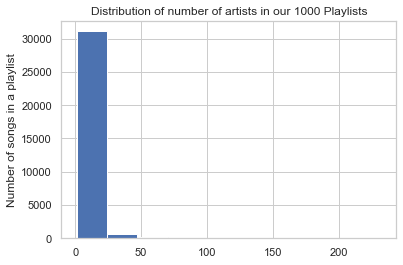

In [1309]:
plt.hist(merged_df['artist_name'].value_counts())
plt.title("Distribution of number of artists in our 1000 Playlists")
plt.ylabel("Count")
plt.ylabel("Number of songs in a playlist")
plt.show()

In [124]:
merged_df.dtypes

Playlist_pos     int64
artist_name     object
track_uri       object
artist_uri      object
track_name      object
album_uri       object
duration_ms      int64
album_name      object
playlist        object
dtype: object

Becasue the current dataset is over 666k songs it will exceed the Spotify API call limit, I decided to drop all duplicated values in track_names, to be able to lower the song count

In [147]:
#drop duplicate songs to clean up dataset, and make api calls closer to limit, 668k rows lowered to 134k
merged_df.drop_duplicates('track_name',inplace = True)

In [148]:
merged_df

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,Throwbacks
1,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone,Throwbacks
2,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit),Throwbacks
3,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified,Throwbacks
4,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot,Throwbacks
...,...,...,...,...,...,...,...,...,...
67911,43,Cole Turner,spotify:track:7e5CVfXtcwJLaWBrGQvvo9,spotify:artist:6BESPq5NL3lWXByDFn6cPj,Here Comes the Hot Stepper,spotify:album:0o2o2lpheMEFaTdgJcE8BK,238253,Red Hot Reggae,Skate Music
67917,49,Jackyl,spotify:track:1Q0ngcqxEr5GpDGfh5VAvZ,spotify:artist:3jdirYL01245TvAH39GfM6,The Lumberjack,spotify:album:1SzvaAWHRI4NN3sRfUdOzW,212106,Jackyl,Skate Music
67926,58,Saturday Night Fever,spotify:track:1yZLRUuMs8sOvFCXyhUeWq,spotify:artist:3PhkrqEEE8JMMo6hf7V9bh,A Fifth of Beethoven,spotify:album:2K7Fj9CYp5qzwXf6hAlZCm,184078,"Disco Hits of The '70s, '80s & '90s",Skate Music
67927,59,Anita Ward,spotify:track:5XHnhjqYz8wqsZO09vudiA,spotify:artist:3Dd6jD1AApgtNoU6SJWR7P,Ring My Bell (Re-Recorded) [Remastered],spotify:album:3hU3gN6GgBoT9MdCzWha02,230880,Ring My Bell (Dubstep Remix),Skate Music


the duplicated songs almost made up for one-fifth of the merged dataset so that cleaned out a lot.

In [149]:
#make sure no repeat of songs
merged_df['track_name'].value_counts()

Gin And Juice (feat. Dat Nigga Daz)                           1
No Problems (feat. Rico Love)                                 1
I Gotta Believe                                               1
Donkey!                                                       1
Butch                                                         1
                                                             ..
Pixel                                                         1
Three Romances for Clarinet and Piano, Op. 94: I. Moderato    1
If You Could Hie to Kolob                                     1
Glide                                                         1
Macumba                                                       1
Name: track_name, Length: 134515, dtype: int64

Decided it was necessary to drop some unrelevant columns, that wouldn't be needed for the Spotify API

In [138]:
to_drop = ['Playlist_pos']
merged_df.drop(to_drop, inplace=True, axis=1)

In [139]:
merged_df

,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,Throwbacks
1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone,Throwbacks
2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit),Throwbacks
3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified,Throwbacks
4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot,Throwbacks
...,...,...,...,...,...,...,...,...
67911,Cole Turner,spotify:track:7e5CVfXtcwJLaWBrGQvvo9,spotify:artist:6BESPq5NL3lWXByDFn6cPj,Here Comes the Hot Stepper,spotify:album:0o2o2lpheMEFaTdgJcE8BK,238253,Red Hot Reggae,Skate Music
67917,Jackyl,spotify:track:1Q0ngcqxEr5GpDGfh5VAvZ,spotify:artist:3jdirYL01245TvAH39GfM6,The Lumberjack,spotify:album:1SzvaAWHRI4NN3sRfUdOzW,212106,Jackyl,Skate Music
67926,Saturday Night Fever,spotify:track:1yZLRUuMs8sOvFCXyhUeWq,spotify:artist:3PhkrqEEE8JMMo6hf7V9bh,A Fifth of Beethoven,spotify:album:2K7Fj9CYp5qzwXf6hAlZCm,184078,"Disco Hits of The '70s, '80s & '90s",Skate Music
67927,Anita Ward,spotify:track:5XHnhjqYz8wqsZO09vudiA,spotify:artist:3Dd6jD1AApgtNoU6SJWR7P,Ring My Bell (Re-Recorded) [Remastered],spotify:album:3hU3gN6GgBoT9MdCzWha02,230880,Ring My Bell (Dubstep Remix),Skate Music


In [136]:
#no null values
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134515 entries, 0 to 68010
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Playlist_pos  134515 non-null  int64 
 1   artist_name   134515 non-null  object
 2   track_uri     134515 non-null  object
 3   artist_uri    134515 non-null  object
 4   track_name    134515 non-null  object
 5   album_uri     134515 non-null  object
 6   duration_ms   134515 non-null  int64 
 7   album_name    134515 non-null  object
 8   playlist      134515 non-null  object
dtypes: int64(2), object(7)
memory usage: 10.3+ MB


Even with the dropped duplicates it was necessary to take an even smaller sample of the dataset, so I took a random sample of around 12000 songs and created that a new dataframe for it

In [172]:
#We have 134515 songs

# It's hard time consuming to bring data from spotify for over 134k songs
# I tried 1000 playlists and spotify didn't allow me to get that much data
# Let's choose a smaller dataset, 12000 songs in random and bring spotify data for those songs
sm_sample = merged_df.sample(n=12000, random_state=42)

In [173]:
sm_sample

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
13845,40,Mariahlynn,spotify:track:3OGuiEDR8XXjaWqbOaVqUA,spotify:artist:4jk4lxjwNCDVIwHyCrUmlk,Once Upon a Time,spotify:album:5AhiDbA3DcMCjpFMFhLHZq,156000,Once Upon a Time,On the Run
6631,13,Neil Sedaka,spotify:track:7GC4k7X9a7NW98p1ODZjZg,spotify:artist:5N6GwJzOcOY5kv8p0NjhYL,Next Door To An Angel,spotify:album:0JWUkNkfTDRWRRTlxz09Ko,144428,All Time Greatest Hits,Oldies
22659,8,Forest Swords,spotify:track:1FYJSBSShfORqU2yUFQGXS,spotify:artist:2VarlUiM6Lw0SA7BvwVPRP,"Friend, You Will Never Learn",spotify:album:74UnLsuHAp1505hHzwcjPR,492080,Engravings,December
30232,24,Boyce Avenue,spotify:track:0LSegQAZFXyKV5EWCBK1He,spotify:artist:7CQwac16i1W5ej8YpuL3dv,Jumper,spotify:album:3aq3323aUMaRXL7WuJcT3b,228434,"New Acoustic Sessions, Vol. 2",Acoustic
21553,138,Genoa Keawe,spotify:track:5VUZ3kwdQHr9rMVkJot15R,spotify:artist:3TOhHfwiR2xQYQFph79xOy,Alika,spotify:album:2LSvzyw8Xt2r11gsaSfPVt,276693,Hana Hou! Vol. 1,Hawaiian
...,...,...,...,...,...,...,...,...,...
59720,40,St Germain,spotify:track:5IN7CHKxzc2FoSFDx1JqS0,spotify:artist:484sZUYmnRXN84zmk3GY1n,Sentimental Mood,spotify:album:7i7UOdfGr4p3xmQX7lOT8z,620240,Boulevard (the complete series),Chill out
2898,57,Omar LinX,spotify:track:0IavpjES4TgnNw2RPYDDey,spotify:artist:6fSNDuge2fLINdnCCbpZx6,Can't Forget,spotify:album:6BAQ9cYT1crGWo9Aqj2VEN,217093,Can't Forget,Rap
2505,9,Henry Gross,spotify:track:4xlz9mvlXko4Ccnb4gLjWJ,spotify:artist:3u2E9OhKS2vkxi08itc25a,Shannon,spotify:album:6DRNAOA2T2T6JMF7oOt8qK,253200,Anchorman,Movie Songs
31295,101,Dennis Sheperd,spotify:track:6VbCaW5zcl9Ir5UxewNtw6,spotify:artist:1wzytoanlxHqWXGCpUxnbY,Fallen Angel - Dennis Sheperd Radio Edit,spotify:album:3bcINm7wpvDgZv8hdF36Ut,214545,"Trance World, Vol. 14",A playlist.


In [174]:
sm_sample['artist_name'].value_counts()

Gucci Mane               27
John Williams            24
Johann Sebastian Bach    21
The Beatles              21
Pearl Jam                19
                         ..
Ashwin Batish             1
Buju Banton               1
330am                     1
Attila                    1
Antonio Orozco            1
Name: artist_name, Length: 7311, dtype: int64

## Spotify Web API Call 
Adding audio features that correspond with the entire random sample of the Spotify Million Playlist dataset.
***

In [ ]:
#get spotify api data
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

client_credentials_manager = SpotifyClientCredentials('', '', None)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [175]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

cid ="9bda17a34ca54cd3bd8d20c35541114c" #get these from spotify for developers website
secret = "b376e9fc5e56446aba3ec1673dd27672"

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [177]:
audtrack_info = []
tracks_uri = list(sm_sample['track_uri'])
counts = list(np.arange(0,12000,100))
for count in counts:
    
    # This is the part we get data from Spotify
    # Usually takes a long time to implement
    for x in tracks_uri[count:count+100]:
        song = sp.audio_features(tracks= x)[0]
        audtrack_info.append(song)
        
# We have a dataframe with info on each track
audtrack_info_df = pd.DataFrame(audtrack_info)
audtrack_info_df.head(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.903,0.612,7,-7.789,1,0.3190,0.0500,0.000123,0.0736,0.6720,100.013,audio_features,3OGuiEDR8XXjaWqbOaVqUA,spotify:track:3OGuiEDR8XXjaWqbOaVqUA,https://api.spotify.com/v1/tracks/3OGuiEDR8XXj...,https://api.spotify.com/v1/audio-analysis/3OGu...,156000,4
1,0.707,0.835,6,-10.608,0,0.0436,0.7120,0.000000,0.3910,0.9400,123.853,audio_features,7GC4k7X9a7NW98p1ODZjZg,spotify:track:7GC4k7X9a7NW98p1ODZjZg,https://api.spotify.com/v1/tracks/7GC4k7X9a7NW...,https://api.spotify.com/v1/audio-analysis/7GC4...,144840,4
2,0.354,0.821,9,-12.092,0,0.1860,0.9570,0.920000,0.0998,0.3280,109.956,audio_features,1FYJSBSShfORqU2yUFQGXS,spotify:track:1FYJSBSShfORqU2yUFQGXS,https://api.spotify.com/v1/tracks/1FYJSBSShfOR...,https://api.spotify.com/v1/audio-analysis/1FYJ...,492080,4
3,0.716,0.446,0,-9.291,1,0.0307,0.0847,0.000000,0.1890,0.6200,90.958,audio_features,0LSegQAZFXyKV5EWCBK1He,spotify:track:0LSegQAZFXyKV5EWCBK1He,https://api.spotify.com/v1/tracks/0LSegQAZFXyK...,https://api.spotify.com/v1/audio-analysis/0LSe...,228435,4
4,0.422,0.279,0,-14.155,1,0.0337,0.5450,0.003120,0.2810,0.6130,138.165,audio_features,5VUZ3kwdQHr9rMVkJot15R,spotify:track:5VUZ3kwdQHr9rMVkJot15R,https://api.spotify.com/v1/tracks/5VUZ3kwdQHr9...,https://api.spotify.com/v1/audio-analysis/5VUZ...,276693,4
5,0.729,0.657,0,-8.752,1,0.0769,0.8110,0.737000,0.0800,0.8790,128.965,audio_features,0RtoJoKE0kSTRgRYQNVzSM,spotify:track:0RtoJoKE0kSTRgRYQNVzSM,https://api.spotify.com/v1/tracks/0RtoJoKE0kST...,https://api.spotify.com/v1/audio-analysis/0Rto...,181387,4
6,0.830,0.628,8,-9.570,0,0.0443,0.1240,0.000003,0.0661,0.9180,117.603,audio_features,54c8y4TUUC78xxCXDuMjyn,spotify:track:54c8y4TUUC78xxCXDuMjyn,https://api.spotify.com/v1/tracks/54c8y4TUUC78...,https://api.spotify.com/v1/audio-analysis/54c8...,189760,4
7,0.555,0.329,5,-9.188,1,0.0279,0.4950,0.015400,0.6690,0.0391,140.038,audio_features,58eKLwmiYrJAqNlv96pwlP,spotify:track:58eKLwmiYrJAqNlv96pwlP,https://api.spotify.com/v1/tracks/58eKLwmiYrJA...,https://api.spotify.com/v1/audio-analysis/58eK...,407973,4
8,0.742,0.302,10,-9.596,1,0.0398,0.6070,0.000000,0.1010,0.4380,78.505,audio_features,51mwvxRXUktJYBXqq9uXuo,spotify:track:51mwvxRXUktJYBXqq9uXuo,https://api.spotify.com/v1/tracks/51mwvxRXUktJ...,https://api.spotify.com/v1/audio-analysis/51mw...,206147,4
9,0.568,0.373,10,-10.428,1,0.0308,0.6260,0.000406,0.0839,0.1930,126.122,audio_features,6yyoKdYcFHdhnBnWHlB6Lu,spotify:track:6yyoKdYcFHdhnBnWHlB6Lu,https://api.spotify.com/v1/tracks/6yyoKdYcFHdh...,https://api.spotify.com/v1/audio-analysis/6yyo...,368267,4


The API call gave me audio features for each of the 12k songs of the sampled dataset which will now have to be merged together to create the final dataset for exploratory data analysis and modeling. Just from looking
at the dataframe, I can already tell there will be quite a few columns such as type, id, uri, etc. that will have to be dropped because they dont add much value for the recommendation system.
The audio features key is shown below: 

## Audio Features Explanation
- **<font color=red>acousticness</font>** confidence measure from 0.0 to 1.0 of whether the track is acoustic.
- **<font color=red>danceability</font>** measure describes how suitable a track is for dancing.
- **<font color=red>duration_ms</font>** is the duration of the song track in milliseconds.
- **<font color=red>energy</font>** represents a perceptual measure of intensity and activity.
- **<font color=red>instrumentalness</font>** predicts whether a track contains vocals or not.
- **<font color=red>loudness</font>** of a track in decibels(dB).
- **<font color=red>liveness</font>** detects the presence of an audience in the recording.
- **<font color=red>speechiness</font>** detects the presence of spoken words in a track
- **<font color=red>time_signature</font>** is an estimated overall time signature of a track.
- **<font color=red>key</font>** the track is in. Integers map to pitches using standard Pitch Class notation.
- **<font color=red>valence</font>** measures from 0.0 to 1.0 describing the musical positiveness (vibe) conveyed by a track.
- **<font color=red>tempo</font>** is in beats per minute (BPM).
- **<font color=red>mode</font>** (Melody) indicates the modality(major or minor) of the song.

In [178]:
audtrack_info_df.shape

(12000, 18)

It is now time to finally merge the sampled dataset (Spotify Million Playlist) and the audio features from the API spotify together

In [1245]:
# merge the 2 dataframes
spotify_df = pd.concat([sm_sample.reset_index(), audtrack_info_df], axis=1)
spotify_df.head(10)

,index,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,13845,40,Mariahlynn,spotify:track:3OGuiEDR8XXjaWqbOaVqUA,spotify:artist:4jk4lxjwNCDVIwHyCrUmlk,Once Upon a Time,spotify:album:5AhiDbA3DcMCjpFMFhLHZq,156000,Once Upon a Time,On the Run,0.903,0.612,7,-7.789,1,0.3190,0.0500,0.000123,0.0736,0.6720,100.013,audio_features,3OGuiEDR8XXjaWqbOaVqUA,spotify:track:3OGuiEDR8XXjaWqbOaVqUA,https://api.spotify.com/v1/tracks/3OGuiEDR8XXj...,https://api.spotify.com/v1/audio-analysis/3OGu...,156000,4
1,6631,13,Neil Sedaka,spotify:track:7GC4k7X9a7NW98p1ODZjZg,spotify:artist:5N6GwJzOcOY5kv8p0NjhYL,Next Door To An Angel,spotify:album:0JWUkNkfTDRWRRTlxz09Ko,144428,All Time Greatest Hits,Oldies,0.707,0.835,6,-10.608,0,0.0436,0.7120,0.000000,0.3910,0.9400,123.853,audio_features,7GC4k7X9a7NW98p1ODZjZg,spotify:track:7GC4k7X9a7NW98p1ODZjZg,https://api.spotify.com/v1/tracks/7GC4k7X9a7NW...,https://api.spotify.com/v1/audio-analysis/7GC4...,144840,4
2,22659,8,Forest Swords,spotify:track:1FYJSBSShfORqU2yUFQGXS,spotify:artist:2VarlUiM6Lw0SA7BvwVPRP,"Friend, You Will Never Learn",spotify:album:74UnLsuHAp1505hHzwcjPR,492080,Engravings,December,0.354,0.821,9,-12.092,0,0.1860,0.9570,0.920000,0.0998,0.3280,109.956,audio_features,1FYJSBSShfORqU2yUFQGXS,spotify:track:1FYJSBSShfORqU2yUFQGXS,https://api.spotify.com/v1/tracks/1FYJSBSShfOR...,https://api.spotify.com/v1/audio-analysis/1FYJ...,492080,4
3,30232,24,Boyce Avenue,spotify:track:0LSegQAZFXyKV5EWCBK1He,spotify:artist:7CQwac16i1W5ej8YpuL3dv,Jumper,spotify:album:3aq3323aUMaRXL7WuJcT3b,228434,"New Acoustic Sessions, Vol. 2",Acoustic,0.716,0.446,0,-9.291,1,0.0307,0.0847,0.000000,0.1890,0.6200,90.958,audio_features,0LSegQAZFXyKV5EWCBK1He,spotify:track:0LSegQAZFXyKV5EWCBK1He,https://api.spotify.com/v1/tracks/0LSegQAZFXyK...,https://api.spotify.com/v1/audio-analysis/0LSe...,228435,4
4,21553,138,Genoa Keawe,spotify:track:5VUZ3kwdQHr9rMVkJot15R,spotify:artist:3TOhHfwiR2xQYQFph79xOy,Alika,spotify:album:2LSvzyw8Xt2r11gsaSfPVt,276693,Hana Hou! Vol. 1,Hawaiian,0.422,0.279,0,-14.155,1,0.0337,0.5450,0.003120,0.2810,0.6130,138.165,audio_features,5VUZ3kwdQHr9rMVkJot15R,spotify:track:5VUZ3kwdQHr9rMVkJot15R,https://api.spotify.com/v1/tracks/5VUZ3kwdQHr9...,https://api.spotify.com/v1/audio-analysis/5VUZ...,276693,4
5,52168,25,Django Reinhardt,spotify:track:0RtoJoKE0kSTRgRYQNVzSM,spotify:artist:5Z1XZyEFY0dewG8faEIiEx,The Sheik of Araby,spotify:album:1xdwTDgU5SuDccLBkV5Ee2,181386,"The Legendary Jazz Guitarist, Vol. 1",Swing,0.729,0.657,0,-8.752,1,0.0769,0.8110,0.737000,0.0800,0.8790,128.965,audio_features,0RtoJoKE0kSTRgRYQNVzSM,spotify:track:0RtoJoKE0kSTRgRYQNVzSM,https://api.spotify.com/v1/tracks/0RtoJoKE0kST...,https://api.spotify.com/v1/audio-analysis/0Rto...,181387,4
6,44737,126,Rick James,spotify:track:54c8y4TUUC78xxCXDuMjyn,spotify:artist:0FrpdcVlJQqibaz5HfBUrL,You And I - Single Version,spotify:album:2e6N9mz4kFIR1sM9givKpK,189760,"Hitsville USA, The Motown Collection 1972-1992",Motown,0.830,0.628,8,-9.570,0,0.0443,0.1240,0.000003,0.0661,0.9180,117.603,audio_features,54c8y4TUUC78xxCXDuMjyn,spotify:track:54c8y4TUUC78xxCXDuMjyn,https://api.spotify.com/v1/tracks/54c8y4TUUC78...,https://api.spotify.com/v1/audio-analysis/54c8...,189760,4
7,52552,15,FC Kahuna,spotify:track:58eKLwmiYrJAqNlv96pwlP,spotify:artist:1UQ5GQDdYPKgbIEn9sMiSg,Hayling (feat. Hafdis Huld),spotify:album:61TdNnA9JCdW456MIRUlCl,407973,Machine Says Yes,chill af,0.555,0.329,5,-9.188,1,0.0279,0.4950,0.015400,0.6690,0.0391,140.038,audio_features,58eKLwmiYrJAqNlv96pwlP,spotify:track:58eKLwmiYrJAqNlv96pwlP,https://api.spotify.com/v1/tracks/58eKLwmiYrJA...,https://api.spotify.com/v1/audio-analysis/58eK...,407973,4
8,48306,40,Us The Duo,spotify:track:51mwvxRXUktJYBXqq9uXuo,spotify:artist:3QGKsAfhZdldQCLuLjk6zl,Missin' You Like Crazy,spotify:album:4sNP3Zx

In [1246]:
spotify_df.shape

(12000, 28)

In [1247]:
spotify_df.describe()

,index,Playlist_pos,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,12000.000000,12000.000000,1.200000e+04,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,1.200000e+04,12000.000000
mean,31726.746750,59.062583,2.399224e+05,0.573154,0.622678,5.275417,-8.305974,0.661750,0.088701,0.286504,0.135095,0.201812,0.480545,121.167883,2.399583e+05,3.905917
std,19537.203257,50.846510,1.095032e+05,0.174611,0.239119,3.610399,4.629801,0.473134,0.101499,0.316372,0.285241,0.178303,0.255983,29.421487,1.095024e+05,0.407118
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.056000e+03,0.000000
25%,14465.250000,19.000000,1.925428e+05,0.460000,0.465000,2.000000,-10.068250,0.000000,0.034800,0.019500,0.000000,0.095000,0.273000,98.004750,1.925730e+05,4.000000
50%,30817.500000,44.000000,2.254930e+05,0.586000,0.658000,5.000000,-7.164500,1.000000,0.047600,0.143000,0.000047,0.126000,0.471500,120.305000,2.254735e+05,4.000000
75%,48507.750000,88.000000,2.679715e+05,0.702000,0.817000,9.000000,-5.241000,1.000000,0.089300,0.507000,0.031975,0.251000,0.683000,139.967000,2.680000e+05,4.000000
max,67793.000000,243.000000,5.425981e+06,0.986000,1.000000,11.000000,2.745000,1.000000,0.962000,0.996000,0.996000,0.995000,0.989000,219.297000,5.425981e+06,5.000000


All audio features besides loudness, tempo & key are scaled from 0 to 1.
Loudness is represented in a range from -60 to 2.74. The lower number represents higher volumes.
Key is a range from 0 to 11. Tempo is from 0 to 219.29
Can see there are certain features that would need to be scaled.

Need to drop various unrelevant columns to make dataset more cleaner for visualizations/modeling

In [1248]:
spotify_df.drop(['track_uri','album_uri', 'artist_uri', 'album_name', 'uri', 'track_href', 'analysis_url', 'Playlist_pos', 'type', 'index', 'playlist'], inplace=True, axis=1)

In [1249]:
spotify_df.head(2)

,artist_name,track_name,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,Mariahlynn,Once Upon a Time,156000,0.903,0.612,7,-7.789,1,0.3190,0.050,0.000123,0.0736,0.672,100.013,3OGuiEDR8XXjaWqbOaVqUA,156000,4
1,Neil Sedaka,Next Door To An Angel,144428,0.707,0.835,6,-10.608,0,0.0436,0.712,0.000000,0.3910,0.940,123.853,7GC4k7X9a7NW98p1ODZjZg,144840,4


In [1250]:
spotify_df.reset_index(drop=True, inplace=True)

Forgot to drop other unrelevant columns, so removing them now

In [1251]:
spotify_df.drop(['id', 'time_signature'],inplace=True, axis=1)

In [1252]:
spotify_df.head(1)

,artist_name,track_name,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,Mariahlynn,Once Upon a Time,156000,0.903,0.612,7,-7.789,1,0.319,0.05,0.000123,0.0736,0.672,100.013,156000


Save cleaned, final DataFrame to a .csv file for future reproducability and to be under (mb) upload [limit](https://docs.github.com/en/repositories/working-with-files/managing-large-files/about-large-files-on-github) for GitHub

In [1318]:
spotify_df.to_csv('spotifymillionandapi.csv')

# EDA Visualizations
***

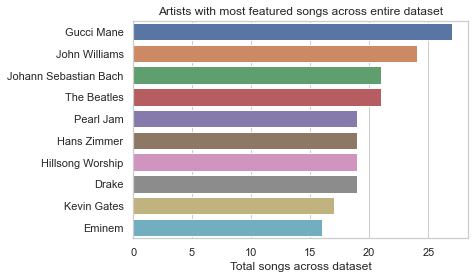

In [1316]:
# Checking which artists are featured most across sampled dataset
values = list(spotify_df['artist_name'].value_counts())
names = spotify_df['artist_name'].value_counts().index.tolist()

ax = sns.barplot(y=names[0:10], x=values[0:10])
ax.set_title('Artists with most featured songs across entire dataset')
ax.set_xlabel('Total songs across dataset');

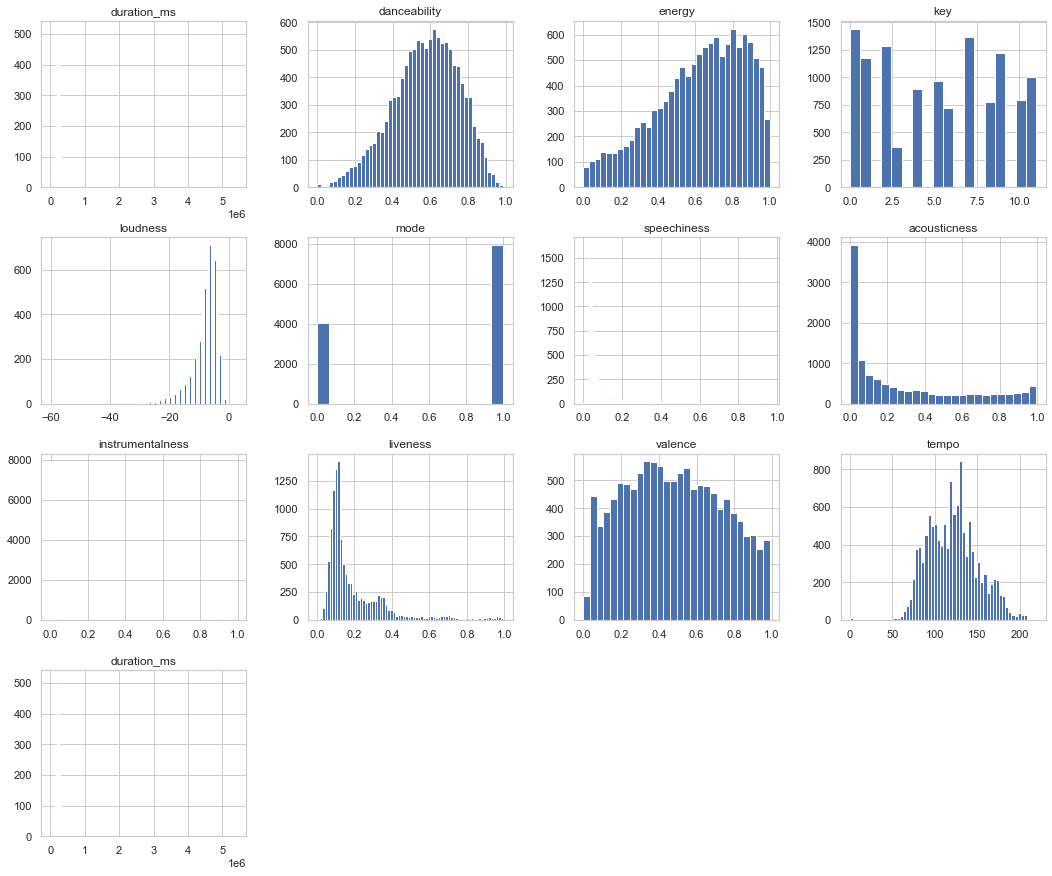

In [1313]:
spotify_df.hist(figsize=(18,15), bins='auto');

Some of the audo features don't have a normal distribution, and everything except for 'liveness' don't have any significant outliers. Danceability, loudness, valence, & energy have some of the best distributions.

Check for Correlation between audio features

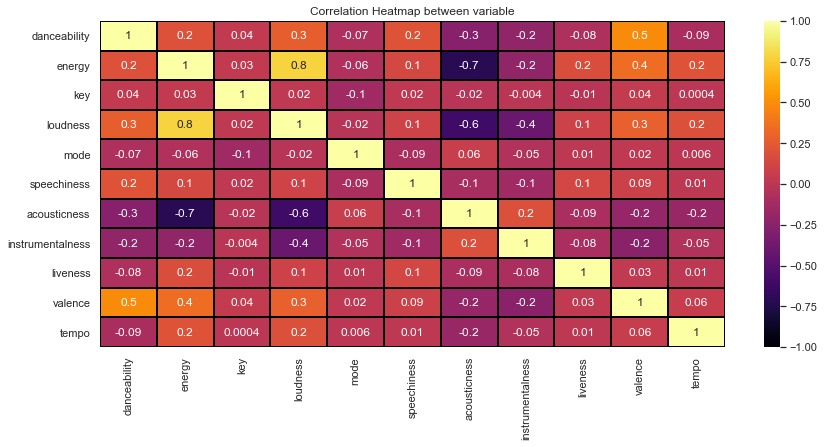

In [1253]:
from matplotlib.patches import Rectangle
corr_df=spotify_df.drop(["duration_ms"],axis=1).corr(method="pearson")
plt.figure(figsize=(14,6))
heatmap=sns.heatmap(corr_df,annot=True,fmt=".1g",vmin=-1,vmax=1,center=0,cmap='inferno',linewidths=1,linecolor="Black")
heatmap.set_title("Correlation Heatmap between variable")
heatmap.set_xticklabels(heatmap.get_xticklabels(),rotation=90);
plt.savefig('correlation.jpg', bbox_inches='tight')

**Observations:**
- Energy vs loudness had highest correlation (0.8) and both danceability vs valence & valence vs energy had 0.5 and 0.4 correlation scores respectively.
- Since these are some of the highest correlated features, I think the content based recommendation system can be based off of those 4.
- Other than that, most of these correlations make sense, especially with energy and loudness having a positive correlation because energy is definitely influenced by what the volume of the song is. 
- Valence & Danceability also make sense since dance songs tend to be a usually happy vibe.

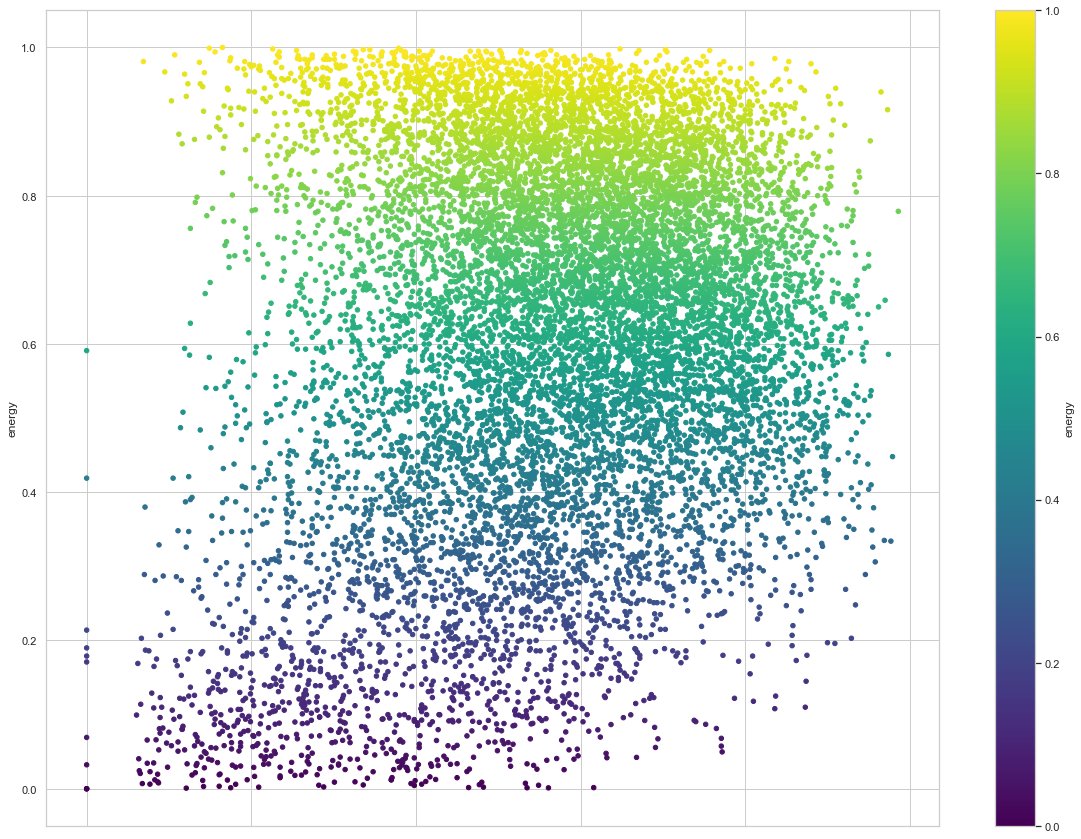

In [1254]:
scatter_energy =  spotify_df.plot.scatter(x='danceability',
                    y = 'energy', figsize=(20, 15),
                    colormap='viridis', c='energy')

**Observations:**
both energy & danceability have a positive correlation when increased

# Data Preparation
***

Due to one of my models being based on cosine similarity, I will scale the audio (sound) features being and reframe the DataFrame to dispaly metadata for each track first and audio features last.

In [1255]:
sound_features = spotify_df[['danceability', 'valence', 'loudness', 'energy']]

mdata = spotify_df.drop(['danceability', 'valence', 'loudness', 'energy'], axis = 1)

In [1256]:
sound_features.head()

,danceability,valence,loudness,energy
0,0.903,0.672,-7.789,0.612
1,0.707,0.940,-10.608,0.835
2,0.354,0.328,-12.092,0.821
3,0.716,0.620,-9.291,0.446
4,0.422,0.613,-14.155,0.279


In [1257]:
#Scale the sound-specific features and organize them in a new DataFrame
scaler = MinMaxScaler()

sound_features2 = pd.DataFrame()

for col in sound_features.columns:    
    
    sound_features2[col] = scaler.fit_transform(sound_features[col].values.reshape(-1,1)).ravel() 

In [1258]:
sound_features2.head()

,danceability,valence,loudness,energy
0,0.915822,0.679474,0.832114,0.612
1,0.717039,0.950455,0.787186,0.835
2,0.359026,0.331648,0.763535,0.821
3,0.726166,0.626896,0.808176,0.446
4,0.427992,0.619818,0.730656,0.279


Merge both metadata and audio features into a new DataFrame

In [1259]:
metadatafeat = mdata.join(sound_features2)

In [1260]:
metadatafeat.head()

,artist_name,track_name,duration_ms,key,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,danceability,valence,loudness,energy
0,Mariahlynn,Once Upon a Time,156000,7,1,0.3190,0.0500,0.000123,0.0736,100.013,156000,0.915822,0.679474,0.832114,0.612
1,Neil Sedaka,Next Door To An Angel,144428,6,0,0.0436,0.7120,0.000000,0.3910,123.853,144840,0.717039,0.950455,0.787186,0.835
2,Forest Swords,"Friend, You Will Never Learn",492080,9,0,0.1860,0.9570,0.920000,0.0998,109.956,492080,0.359026,0.331648,0.763535,0.821
3,Boyce Avenue,Jumper,228434,0,1,0.0307,0.0847,0.000000,0.1890,90.958,228435,0.726166,0.626896,0.808176,0.446
4,Genoa Keawe,Alika,276693,0,1,0.0337,0.5450,0.003120,0.2810,138.165,276693,0.427992,0.619818,0.730656,0.279


There is now a well-made DataFrame with scaled audio features for which we will be modeling on. It's now time to recommend some tracks.


Below is a helper function 

In [1261]:
def get_index_from_name(name):
    '''
    This function returns the index of the row when given a song name
    '''
    return metadatafeat[metadatafeat["track_name"]==name].index.tolist()[0]

# Recommendation Baseline Model - Cosine Similarity (Artist Discography only)
For the baseline I wanted to see if my model could just recommend songs based on just a song's artist's discography.
The function returns a list of 'n' recommendations when I enter in a track
***

To start, I had to use a count vectorizer to encode the names of the singers as vectors, which the cosine similarity model can measure how closely related the songs by same artist are.

In [1262]:
cv = CountVectorizer()
cv_data = cv.fit_transform(metadatafeat['artist_name'])

cos_sim = cosine_similarity(cv_data,cv_data)

In [1263]:
def recommend_songs_same_artist(title, count):
    
    #Find index of song
    idx = get_index_from_name(title)
    artist = metadatafeat.iloc[idx].artist_name
    
    #calculate similarity and put it into a list sorted by highest sim score
    sim_scores = list(enumerate(cos_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # calculate number of scores and put indecies in a list
    sim_scores = sim_scores[1:(count+1)]
    song_indices = [i[0] for i in sim_scores]
    
    print(f'These are {count} songs similar to {title} by {artist}:')
    return metadatafeat.track_name.iloc[song_indices]

In [1264]:
recommend_songs_same_artist("Diamonds Dancing", 5)

These are 5 songs similar to Diamonds Dancing by Drake:


1854                      Still Here
1880                Diamonds Dancing
3840                   Madiba Riddim
4202                        Light Up
4428    HYFR (Hell Ya Fucking Right)
Name: track_name, dtype: object

In [1265]:
recommend_songs_same_artist("My Chain", 5)

These are 5 songs similar to My Chain by Gucci Mane:


941                             Iced Out Bart
1105                         No Sleep - Intro
1278    Party Animal - Explicit Album Version
1347                                 My Chain
1542                            Tho Freestyle
Name: track_name, dtype: object

**Observations:** These songs are all by the same artists so that baseline is working of recommending songs by the same artist based on their discography.

# Model 1: Cosine Similarity by audio features

The goal of this is by using cosine similarity on the audio features (danceability, valence, loudness & energy) of a given song to recommend other songs in the spotify_df dataset.
***

In [1266]:
def recomend_songs_by_audio_similarity(data, song, artist):
    
    try: 
        track_and_artist_data = data[(data['track_name'] == song) & (data["artist_name"]== artist)]

        similar_songs = data.copy()

        audio_properties = similar_songs.loc[:,['danceability', 'valence', 'loudness', 'energy']]

        #Calculate similiary of all songs to the one we want
        similar_songs['Similarity with song'] = cosine_similarity(audio_properties, audio_properties.to_numpy()[track_and_artist_data.index[0],None]).squeeze()

        similar_songs.rename(columns={'track_name': f'Songs Similar to {song}'}, inplace=True)

        similar_songs = similar_songs.sort_values(by= 'Similarity with song', ascending = False)

        similar_songs = similar_songs[['artist_name', f'Songs Similar to {song}',
          'danceability', 'energy', 'loudness', 'valence']]

        similar_songs.reset_index(drop=True, inplace=True)

        return similar_songs.iloc[0:12]
    
    except:
        print("Unfortunately, this song is not included in our dataset") 

In [1267]:
recomend_songs_by_audio_similarity(metadatafeat, "Magnolia", "Playboi Carti")

,artist_name,Songs Similar to Magnolia,danceability,energy,loudness,valence
0,Playboi Carti,Magnolia,0.802231,0.582,0.839541,0.447927
1,Migos,Story I Tell,0.789047,0.576,0.817228,0.435794
2,Young Dolph,All Of Them,0.809331,0.589,0.855144,0.444894
3,Trey Songz,"Touchin, Lovin (feat. Nicki Minaj)",0.824544,0.580,0.849088,0.447927
4,22 Savage,Gotta Blast,0.795132,0.580,0.814312,0.433771
5,G-Eazy,Buddha,0.755578,0.543,0.812511,0.421638
6,Ty Dolla $ign,Campaign (feat. Future) - Charlie Heat Remix,0.813387,0.585,0.869105,0.476239
7,Pardison Fontaine,It's a Go,0.825558,0.603,0.879608,0.490394
8,George Acosta,I Know - Gerry C Mix,0.799189,0.559,0.833038,0.421638
9,2 Chainz,I Luv Dem Strippers,0.869168,0.633,0.873297,0.472194


In [1268]:
recomend_songs_by_audio_similarity(metadatafeat, "My Time", "Fabolous")

,artist_name,Songs Similar to My Time,danceability,energy,loudness,valence
0,Fabolous,My Time,0.603448,0.819,0.857662,0.503539
1,Rev. a. Samar Biggham,Every Praise,0.609533,0.817,0.862682,0.504550
2,Destra,On the Floor (feat. Mr. Vegas),0.641988,0.860,0.899992,0.536906
3,Stu Larsen,Paper Sails,0.581136,0.799,0.832433,0.496461
4,Demun Jones,Tannerite (Remix),0.622718,0.839,0.866906,0.517695
5,Antix,Take 'em Back,0.611562,0.850,0.885776,0.516684
6,Kevin Gates,Money Over Here,0.560852,0.762,0.810232,0.478261
7,Childish Gambino,Fire Fly,0.632860,0.881,0.897346,0.534884
8,Samba Squad,Bateria,0.616633,0.856,0.869790,0.518706
9,Neon Trees,"Lessons In Love (All Day, All Night)",0.619675,0.838,0.884995,0.537917


In [1269]:
recomend_songs_by_audio_similarity(metadatafeat, "SeeSaw", "Jamie xx")

,artist_name,Songs Similar to SeeSaw,danceability,energy,loudness,valence
0,Jamie xx,SeeSaw,0.633874,0.682,0.766882,0.185035
1,Tchami,Prophecy,0.773834,0.827,0.925078,0.229525
2,Boyinaband,Spectrum (feat. Cryaotic & Minx),0.712982,0.783,0.870205,0.188069
3,Kranium,Stamina,0.723124,0.738,0.852339,0.213347
4,Thomston,Rocketfuel,0.703854,0.726,0.851972,0.191102
5,GRiZ,For The Love (Autograf Remix),0.742394,0.753,0.873902,0.222447
6,Dvice,"Hablame 2 (feat. Alex Kyza, Darkiel, Ñengo Flo...",0.752535,0.760,0.884899,0.201213
7,The Chemical Brothers,Reflexion,0.691684,0.791,0.850570,0.223458
8,Tiësto,Maximal Crazy - Extended Mix,0.699797,0.786,0.894924,0.175935
9,Disclosure,Nocturnal - Disclosure V.I.P.,0.724138,0.800,0.847542,0.177958


**Observations:** These recommendations seem mostly accurate except for a few out of sorts. They all sound quite similar to each other, when you listen to them.

In [1270]:
Recc1 = recomend_songs_by_audio_similarity(metadatafeat, "Magnolia", "Playboi Carti")
Recc1 = recomend_songs_by_audio_similarity(metadatafeat, "Magnolia", "Playboi Carti")[Recc1.columns[0:2]]

The recommendation list for "Magnolia" by Playboi Carti was saved as a Series that can be used to be compared with the other models later. 

In [1271]:
Recc1.columns = ['Artist Name', 'Track']

In [1272]:
Recc1 = Recc1[['Track', 'Artist Name']]

Created a separate DataFrame for my first recommendation model result that can be joined with the other 3 later.

In [1273]:
Recc1 = pd.DataFrame(Recc1, columns =['Track', 'Artist Name'])
Recc1['Cosine Similarity'] = Recc1['Track'].str.cat(Recc1['Artist Name'],sep=" by: ")
Recc1 = Recc1.iloc[:,-1:]

# Model 2: Nearest Neighbors with Brute Force
This model will be used to find the nearest neighbors to the song we enter and see what the results are. It will be using Brute Force.
***

In [1274]:
#check for non numerical features, if there are any drop them to run model
metadatafeat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist_name       12000 non-null  object 
 1   track_name        12000 non-null  object 
 2   duration_ms       12000 non-null  int64  
 3   key               12000 non-null  int64  
 4   mode              12000 non-null  int64  
 5   speechiness       12000 non-null  float64
 6   acousticness      12000 non-null  float64
 7   instrumentalness  12000 non-null  float64
 8   liveness          12000 non-null  float64
 9   tempo             12000 non-null  float64
 10  duration_ms       12000 non-null  int64  
 11  danceability      12000 non-null  float64
 12  valence           12000 non-null  float64
 13  loudness          12000 non-null  float64
 14  energy            12000 non-null  float64
dtypes: float64(9), int64(4), object(2)
memory usage: 1.4+ MB


Because of this model requirements, I had to drop all non-numerical columns as shown below.

In [1275]:
nobj_metafeat = metadatafeat.drop(columns=['artist_name', 'track_name'])

In [1276]:
spotify_nn = NearestNeighbors(metric='manhattan', n_neighbors=13, algorithm='brute').fit(nobj_metafeat)

The indicies get the recommended neighbors while the distances will be used to evaluate metrics later.

In [1277]:
distances, indices = spotify_nn.kneighbors(nobj_metafeat)

In [1278]:
def recommend_tracks(track=None,id=None):
    if id:
        for id in indices[id][1:]:
            print(metadatafeat.iloc[id]["track_name"])
    if track:
        recommendations = []
        found_id = get_index_from_name(track)
        for id in indices[found_id][1:]:
            recommendations.append((metadatafeat.iloc[id]["track_name"], metadatafeat.iloc[id]["artist_name"]))
            print(metadatafeat.iloc[id]["track_name"], metadatafeat.iloc[id]["artist_name"])
        return recommendations

In [1279]:
Recc2 = recommend_tracks("Magnolia")

Bout 2 Blow Empire Cast
Drop It (feat. Sage the Gemini) Wonder Broz
La Misma Gran Señora Jenni Rivera
High - US Radio Edit Peking Duk
Zombies Ate My Neighbors Single File
Gimme The Mic Limp Bizkit
Christian Lady Tommy Ellison
Everything I Need Kutless
bodyache (Empress Of Remix) Purity Ring
Hiding Out Pete Townshend
Parker's Mood - 2000 Remastered Version Charlie Parker
Money Rock'N'Roll The Jon Spencer Blues Explosion


**Observations:** These recommendations are all over the place, definitely worse than the cosine similarity model, but still results will be saved.

In [1280]:
Recc2 = pd.DataFrame(Recc2, columns =['Track', 'Artist Name'])
Recc2['NN with Brute Force'] = Recc2['Track'].str.cat(Recc2['Artist Name'],sep=" by: ")
Recc2 = Recc2.iloc[:,-1:]

# Model 3: Nearest Neighbors with Ball-Tree
Change up nearest neighbors metric and algorithm to see if there are better or worse results.
***

In [1281]:
spotify_nn2 = NearestNeighbors(metric='euclidean', n_neighbors=13, algorithm='ball_tree', leaf_size=45).fit(nobj_metafeat)

In [1282]:
distances2, indices2 = spotify_nn2.kneighbors(nobj_metafeat)

In [1283]:
def recommend_tracks_2(track=None,id=None):
    if id:
        for id in indices2[id][1:]:
            print(metadatafeat.iloc[id]["track_name"])
    if track:
        recommendations = []
        found_id = get_index_from_name(track)
        for id in indices2[found_id][1:]:
            recommendations.append((metadatafeat.iloc[id]["track_name"], metadatafeat.iloc[id]["artist_name"]))
            print(metadatafeat.iloc[id]["track_name"], metadatafeat.iloc[id]["artist_name"])
        return recommendations

In [1284]:
Recc3 = recommend_tracks_2("Magnolia")

Bout 2 Blow Empire Cast
High - US Radio Edit Peking Duk
Drop It (feat. Sage the Gemini) Wonder Broz
Zombies Ate My Neighbors Single File
Gimme The Mic Limp Bizkit
La Misma Gran Señora Jenni Rivera
Christian Lady Tommy Ellison
Hiding Out Pete Townshend
Parker's Mood - 2000 Remastered Version Charlie Parker
Everything I Need Kutless
bodyache (Empress Of Remix) Purity Ring
Money Rock'N'Roll The Jon Spencer Blues Explosion


**Observations:** These recommendations really weren't at all that different than the brute force nearest-neighbors model, but still the results have to be saved.

In [1285]:
Recc3 = pd.DataFrame(Recc3, columns =['Track', 'Artist Name'])
Recc3['NN with Ball Tree'] = Recc3['Track'].str.cat(Recc3['Artist Name'],sep=" by: ")
Recc3 = Recc3.iloc[:,-1:]

# Model 4: KNN Clusters
For this recommendation model, I used clustering to create a feature using K-Means and added it to the the DataFrame, which then all features except for my four main features were dropped to determine how similar the 
song was to each other.
***

In [1286]:
#create a pipeline for clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=11))])
X = nobj_metafeat.select_dtypes(np.number)
cluster_pipeline.fit(X)
nobj_metafeat['cluster'] = cluster_pipeline.predict(X)

In [1287]:
knn_dropped = nobj_metafeat.drop(columns=['duration_ms', 'acousticness','instrumentalness', 'key', 'liveness', 'mode', 'speechiness', 'tempo'])

In [1288]:
spotify_nn3 = NearestNeighbors(n_neighbors=13, algorithm='kd_tree', leaf_size = 40, metric = 'euclidean').fit(knn_dropped)

In [1289]:
distances3, indices3 = spotify_nn3.kneighbors(knn_dropped)

In [1290]:
def recommend_tracks_3(track=None):
        recommendations = []
        found_id = get_index_from_name(track)
        for id in indices3[found_id][1:]:
            recommendations.append((metadatafeat.iloc[id]["track_name"], metadatafeat.iloc[id]["artist_name"]))
            print(metadatafeat.iloc[id]["track_name"], metadatafeat.iloc[id]["artist_name"])
        return recommendations

In [1292]:
Recc4 = recommend_tracks_3("Magnolia")

All Of Them Young Dolph
Gotta Blast 22 Savage
Cazal Zuna
Sadity - Main Version - Explicit Too $hort
Came Thru/Easily Chuck Inglish
Game On Demo Taped
My Yout (feat. Collie Buddz) Joey Bada$$
Phones SlimJesus
Cool Back Kid Ink
It's a Go Pardison Fontaine
Buddha G-Eazy
Wobbin Packy


This is mostly hiphop and sounds the best out of all model, so this is much better.

In [1293]:
Recc4 = pd.DataFrame(Recc4, columns =['Song', 'Artist Name'])
Recc4['KNN Clustering'] = Recc4['Song'].str.cat(Recc4['Artist Name'],sep=" by: ")
Recc4 = Recc4.iloc[:,-1:]

In [1294]:
Recc1.reset_index(drop=True, inplace=True)
Recc2.reset_index(drop=True, inplace=True)
Recc3.reset_index(drop=True, inplace=True)
Recc4.reset_index(drop=True, inplace=True)

## Evaluating Recommendations

In [1295]:
Recommendations_df = pd.concat([Recc1, Recc2, Recc3, Recc4], axis='columns')
Recommendations_df

,Cosine Similarity,NN with Brute Force,NN with Ball Tree,KNN Clustering
0,Magnolia by: Playboi Carti,Bout 2 Blow by: Empire Cast,Bout 2 Blow by: Empire Cast,All Of Them by: Young Dolph
1,Story I Tell by: Migos,Drop It (feat. Sage the Gemini) by: Wonder Broz,High - US Radio Edit by: Peking Duk,Gotta Blast by: 22 Savage
2,All Of Them by: Young Dolph,La Misma Gran Señora by: Jenni Rivera,Drop It (feat. Sage the Gemini) by: Wonder Broz,Cazal by: Zuna
3,"Touchin, Lovin (feat. Nicki Minaj) by: Trey Songz",High - US Radio Edit by: Peking Duk,Zombies Ate My Neighbors by: Single File,Sadity - Main Version - Explicit by: Too $hort
4,Gotta Blast by: 22 Savage,Zombies Ate My Neighbors by: Single File,Gimme The Mic by: Limp Bizkit,Came Thru/Easily by: Chuck Inglish
5,Buddha by: G-Eazy,Gimme The Mic by: Limp Bizkit,La Misma Gran Señora by: Jenni Rivera,Game On by: Demo Taped
6,Campaign (feat. Future) - Charlie Heat Remix b...,Christian Lady by: Tommy Ellison,Christian Lady by: Tommy Ellison,My Yout (feat. Collie Buddz) by: Joey Bada$$
7,It's a Go by: Pardison Fontaine,Everything I Need by: Kutless,Hiding Out by: Pete Townshend,Phones by: SlimJesus
8,I Know - Gerry C Mix by: George Acosta,bodyache (Empress Of Remix) by: Purity Ring,Parker's Mood - 2000 Remastered Version by: Ch...,Cool Back by: Kid Ink
9,I Luv Dem Strippers by: 2 Chainz,Hiding Out by: Pete Townshend,Everything I Need by: Kutless,It's a Go by: Pardison Fontaine


**<font color=Red>KNN Clustering Distance Score</font>**

In [1296]:
avg_dist3 = distances3.mean()
print(avg_dist3)

0.07117793478317484


**<font color=Red>Nearest Neighbors with Ball Tree Distance Score</font>**

In [1297]:
avg_dist2 = distances2.mean()
print(avg_dist2)

1497.5741263153411


**<font color=Red>Nearest Neighbors w/ Brute Force Distance Score</font>**

In [1298]:
avg_dist = distances.mean()
print(avg_dist)

2137.047648714615


**Observations:** I modeled each model off the same song of "Magnolia" by Playboi Carti. Cosine Similarity & KNN Clustering recommendation lists sounded very similar to each other when I listened to them. Both nearest neighbor models were essentially similar to each other in terms of the names of tracks but when I listened to them they seemed completely out of sorts to each other. The mean distances between the features for both NN models were also extremely high (both over 1450 distance points) while KNN clustering was only 0.07 distance points. Now it is time to test the best model, KNN Clustering out with some other songs.

# Final Model

In [1299]:
spotify_nn4 = NearestNeighbors(n_neighbors=13, algorithm='kd_tree', leaf_size = 40, metric = 'euclidean').fit(knn_dropped)

In [1300]:
distances4, indices4 = spotify_nn4.kneighbors(knn_dropped)

In [1301]:
def recommend_tracks_4(track=None):
        recommendations = []
        found_id = get_index_from_name(track)
        for id in indices4[found_id][1:]:
            recommendations.append((metadatafeat.iloc[id]["track_name"], metadatafeat.iloc[id]["artist_name"]))
            print(metadatafeat.iloc[id]["track_name"], metadatafeat.iloc[id]["artist_name"])
        return recommendations

In [1302]:
FinalRec = recommend_tracks_4("For The Love (Autograf Remix)")

Stamina Kranium
Spectrum - Maya Jane Coles Remix Florence + The Machine
Spectrum (feat. Cryaotic & Minx) Boyinaband
Lie to Me Future
Let's Go Home (Pegato Remix) Eklo
SheDGAF Broderick Batts
Nocturnal - Disclosure V.I.P. Disclosure
Walk On In (feat. Ratcatcher) Doc Daneeka
Test Saro
What's Happenin' Don Mega
He’s A A A Able The Nevels Sisters
Esta Noche Travesura Boricua Boys


In [1303]:
FinalRec = pd.DataFrame(FinalRec, columns =['Song', 'Artist Name'])
FinalRec['KNN Clustering(For The Love (Autograf Remix))'] = FinalRec['Song'].str.cat(FinalRec['Artist Name'],sep=" by: ")
FinalRec = FinalRec.iloc[:,-1:]

In [1304]:
FinalRec2 = recommend_tracks_4("PA Nights")

Gin and Juice Cold Chilling Collective
Never Seen Runaway (Lost Soul & Genjo Mix) Jay Kill & The Hustle Standard
Empty Words Christina Aguilera
Make a Baby Raheem DeVaughn
Fcknu Caleb Groh
Bass Ackwards Tech N9ne
One Man Can Change The World Big Sean
Rescue Him Kimbra
Same Ol' Road Dredg
Lightsaber // Saviour Yung Lean
Same Script, Different Cast Whitney Houston
Losing the Agreement Max and the Moon


In [1305]:
FinalRec2 = pd.DataFrame(FinalRec2, columns =['Song', 'Artist Name'])
FinalRec2['KNN Clustering(PA Nights)'] = FinalRec2['Song'].str.cat(FinalRec2['Artist Name'],sep=" by: ")
FinalRec2 = FinalRec2.iloc[:,-1:]

In [1306]:
Final_Recommendations_df = results = pd.concat([FinalRec, FinalRec2], axis='columns')
Final_Recommendations_df

,KNN Clustering(For The Love (Autograf Remix)),KNN Clustering(PA Nights)
0,Stamina by: Kranium,Gin and Juice by: Cold Chilling Collective
1,Spectrum - Maya Jane Coles Remix by: Florence ...,Never Seen Runaway (Lost Soul & Genjo Mix) by:...
2,Spectrum (feat. Cryaotic & Minx) by: Boyinaband,Empty Words by: Christina Aguilera
3,Lie to Me by: Future,Make a Baby by: Raheem DeVaughn
4,Let's Go Home (Pegato Remix) by: Eklo,Fcknu by: Caleb Groh
5,SheDGAF by: Broderick Batts,Bass Ackwards by: Tech N9ne
6,Nocturnal - Disclosure V.I.P. by: Disclosure,One Man Can Change The World by: Big Sean
7,Walk On In (feat. Ratcatcher) by: Doc Daneeka,Rescue Him by: Kimbra
8,Test by: Saro,Same Ol' Road by: Dredg
9,What's Happenin' by: Don Mega,Lightsaber // Saviour by: Yung Lean


**<font color=Green>KNN Clustering Distance Score</font>**

In [1244]:
avg_dist4 = distances4.mean()
print(avg_dist4)

0.07146915346939511


# Conclusions

KNN Clustering model was the best based on my subjective hearing analysis. It had the lowest mean recommendation distance between selected features and it sounded the most similar. This model was also used on two other songs "(For The Love (Autograf Remix)" by GriZ and "PA Nights" by Mac Miller and both recommended lists sounded similar as well as their average distance between features (0.07 distance points) was identical with "Magnolia's" distance score. K Means Clustering model was the best. Cosine Similarity was also very good but towards the end of the recommendation list, the songs in my opinion didn't sound as close to each other. As compared to the other models especialy KNN with Brute Force & Ball Tree the average recommendations mean distance was significantly less with clustering (.07 points) while the two KNN models were above 1400 points each. 

# Limitations

Because the final dataset I modeled on was only about 12000 songs which is a severe lack of representation from Spotify's 70 million song database.

# Future Work

- Maybe add genres to dataset along with the other current audio features to see if recommendations improve. Also find out if there is a way to included more than one single artist and song to find similar songs.
- Create an app through [Flask](https://flask.palletsprojects.com/en/2.0.x/) or [Streamlit](https://streamlit.io/) to better visualize the recommendation systems.
- Make a collaborative-filtered Recommendation System based on what other users listen to compared to my own streaming history
- Make this same type of recommendation system I made with Spotify API with the Apple Music API as well.